Baseline average response time: 49.73
RL average response time: 58.81


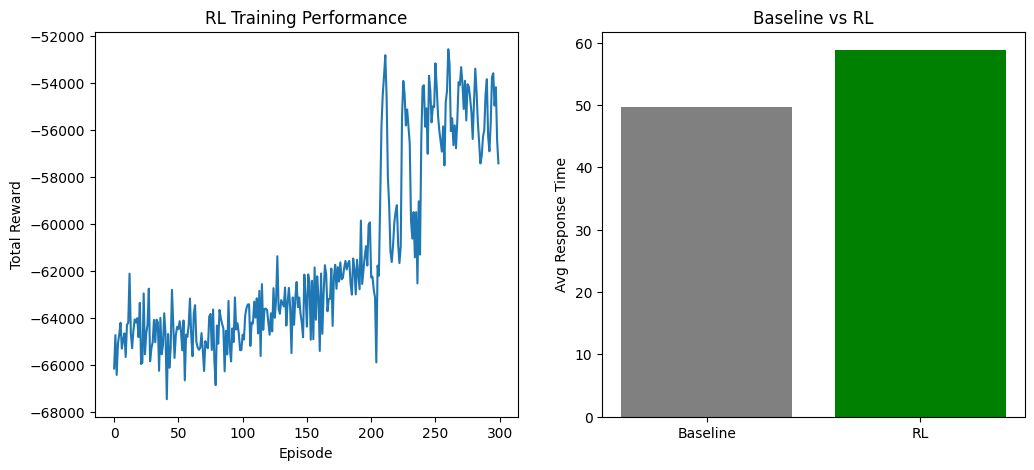

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# Load dataset
df = pd.read_csv("synthetic_calls.csv")

# --- Fix column names ---
if "timeReceived" in df.columns:
    df = df.sort_values("timeReceived").reset_index(drop=True)
elif "Timestamp" in df.columns:
    # convert Timestamp to datetime and then numeric
    df["timeReceived"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("timeReceived").reset_index(drop=True)
else:
    # fallback: just use index as time
    df["timeReceived"] = range(len(df))

# Extract call data
calls = df[["timeReceived", "X", "Y", "Severity"]].values

# Grid setup
GRID_SIZE = 100
AMB_SPEED = 1.0  # units per timestep

# RL parameters
Z = 5  # 5x5 zones
NUM_ZONES = Z * Z
alpha = 0.1
gamma = 0.95
epsilon = 0.2
episodes = 300

def zone_id(x, y):
    return (x // (GRID_SIZE // Z)) * Z + (y // (GRID_SIZE // Z))

# Environment
class ERSEnv:
    def __init__(self, calls):
        self.calls = calls
        self.reset()

    def reset(self):
        self.t = 0
        self.ambulance_zone = NUM_ZONES // 2
        self.done = False
        return (self.ambulance_zone,)

    def step(self, action):
        self.ambulance_zone = action
        # process call if within timeline
        if self.t < len(self.calls):
            _, x, y, sev = self.calls[self.t]
            cx, cy = divmod(self.ambulance_zone, Z)
            zx = (GRID_SIZE // Z) * cx + (GRID_SIZE // (2*Z))
            zy = (GRID_SIZE // Z) * cy + (GRID_SIZE // (2*Z))
            dist = abs(zx - x) + abs(zy - y)
            response_time = dist / AMB_SPEED
            reward = -response_time
        else:
            reward = 0
        self.t += 1
        if self.t >= len(self.calls):
            self.done = True
        return (self.ambulance_zone,), reward, self.done

# Q-learning
Q = defaultdict(lambda: np.zeros(NUM_ZONES))
env = ERSEnv(calls)
rewards_per_episode = []

for ep in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        if random.random() < epsilon:
            action = random.randrange(NUM_ZONES)
        else:
            action = np.argmax(Q[state])
        next_state, reward, done = env.step(action)
        total_reward += reward
        best_next = np.max(Q[next_state])
        Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])
        state = next_state
    rewards_per_episode.append(total_reward)

# Evaluate baseline (always central zone)
def baseline_policy(calls):
    total_rt = 0
    for _, x, y, sev in calls:
        cx, cy = divmod(NUM_ZONES // 2, Z)
        zx = (GRID_SIZE // Z) * cx + (GRID_SIZE // (2*Z))
        zy = (GRID_SIZE // Z) * cy + (GRID_SIZE // (2*Z))
        dist = abs(zx - x) + abs(zy - y)
        total_rt += dist / AMB_SPEED
    return total_rt / len(calls)

baseline_avg = baseline_policy(calls)

# Evaluate RL policy
def rl_policy(calls, Q):
    env = ERSEnv(calls)
    state = env.reset()
    total_rt = 0
    count = 0
    while not env.done:
        action = np.argmax(Q[state])
        next_state, reward, done = env.step(action)
        total_rt += -reward  # since reward = -response time
        count += 1
        state = next_state
    return total_rt / count

rl_avg = rl_policy(calls, Q)

print(f"Baseline average response time: {baseline_avg:.2f}")
print(f"RL average response time: {rl_avg:.2f}")

# --- Plots ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("RL Training Performance")

plt.subplot(1,2,2)
plt.bar(["Baseline", "RL"], [baseline_avg, rl_avg], color=["gray", "green"])
plt.ylabel("Avg Response Time")
plt.title("Baseline vs RL")
plt.show()


Final Baseline avg weighted response time: 95.74
Final RL avg weighted response time: 112.66


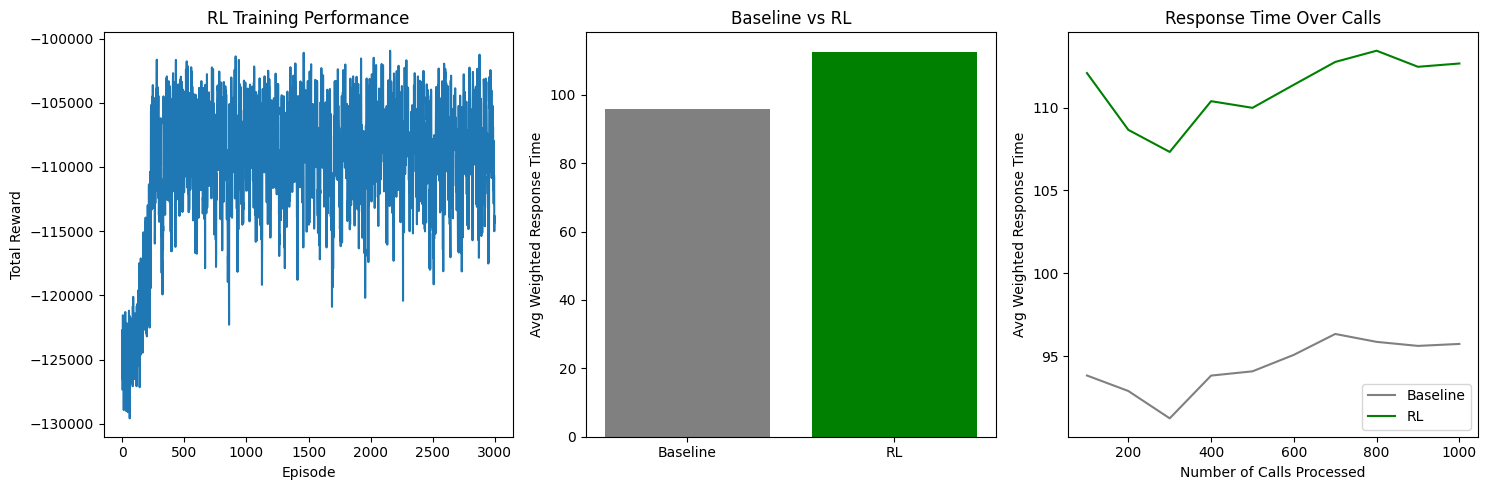

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# Load dataset
df = pd.read_csv("synthetic_calls.csv")

# --- Fix column names ---
if "timeReceived" in df.columns:
    df = df.sort_values("timeReceived").reset_index(drop=True)
elif "Timestamp" in df.columns:
    df["timeReceived"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("timeReceived").reset_index(drop=True)
else:
    df["timeReceived"] = range(len(df))

# Severity weights
severity_weights = {"Critical": 3.0, "Moderate": 2.0, "Low": 1.0}

# Extract call data
calls = df[["timeReceived", "X", "Y", "Severity"]].values

# Grid setup
GRID_SIZE = 100
AMB_SPEED = 1.0  # units per timestep

# RL parameters
Z = 5  # 5x5 zones
NUM_ZONES = Z * Z
alpha = 0.1
gamma = 0.95
epsilon = max(0.01, epsilon * 0.995)
episodes = 3000

def zone_id(x, y):
    return (x // (GRID_SIZE // Z)) * Z + (y // (GRID_SIZE // Z))

# Environment
class ERSEnv:
    def __init__(self, calls):
        self.calls = calls
        self.reset()

    def reset(self):
        self.t = 0
        self.ambulance_zone = NUM_ZONES // 2
        self.done = False
        return (self.ambulance_zone,)

    def step(self, action):
        self.ambulance_zone = action
        if self.t < len(self.calls):
            _, x, y, sev = self.calls[self.t]
            cx, cy = divmod(self.ambulance_zone, Z)
            zx = (GRID_SIZE // Z) * cx + (GRID_SIZE // (2*Z))
            zy = (GRID_SIZE // Z) * cy + (GRID_SIZE // (2*Z))
            dist = abs(zx - x) + abs(zy - y)
            response_time = dist / AMB_SPEED
            weight = severity_weights.get(sev, 1.0)
            reward = -(response_time * weight)
        else:
            reward = 0
        self.t += 1
        if self.t >= len(self.calls):
            self.done = True
        return (self.ambulance_zone,), reward, self.done

# Q-learning
Q = defaultdict(lambda: np.zeros(NUM_ZONES))
env = ERSEnv(calls)
rewards_per_episode = []

for ep in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        if random.random() < epsilon:
            action = random.randrange(NUM_ZONES)
        else:
            action = np.argmax(Q[state])
        next_state, reward, done = env.step(action)
        total_reward += reward
        best_next = np.max(Q[next_state])
        Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])
        state = next_state
    rewards_per_episode.append(total_reward)

# Evaluate baseline (always central zone)
def baseline_policy(calls):
    avg_times = []
    total_rt = 0
    for i, (_, x, y, sev) in enumerate(calls):
        cx, cy = divmod(NUM_ZONES // 2, Z)
        zx = (GRID_SIZE // Z) * cx + (GRID_SIZE // (2*Z))
        zy = (GRID_SIZE // Z) * cy + (GRID_SIZE // (2*Z))
        dist = abs(zx - x) + abs(zy - y)
        weight = severity_weights.get(sev, 1.0)
        total_rt += dist / AMB_SPEED * weight
        if (i+1) % 100 == 0:
            avg_times.append(total_rt / (i+1))
    return avg_times

# Evaluate RL policy
def rl_policy(calls, Q):
    env = ERSEnv(calls)
    state = env.reset()
    avg_times = []
    total_rt = 0
    count = 0
    while not env.done:
        action = np.argmax(Q[state])
        next_state, reward, done = env.step(action)
        total_rt += -reward  # since reward = -response time * severity weight
        count += 1
        if count % 100 == 0:
            avg_times.append(total_rt / count)
        state = next_state
    return avg_times

baseline_times = baseline_policy(calls)
rl_times = rl_policy(calls, Q)

print(f"Final Baseline avg weighted response time: {baseline_times[-1]:.2f}")
print(f"Final RL avg weighted response time: {rl_times[-1]:.2f}")

# --- Plots ---
plt.figure(figsize=(15,5))

# RL Training Curve
plt.subplot(1,3,1)
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("RL Training Performance")

# Comparison bar chart
plt.subplot(1,3,2)
plt.bar(["Baseline", "RL"], [baseline_times[-1], rl_times[-1]], color=["gray", "green"])
plt.ylabel("Avg Weighted Response Time")
plt.title("Baseline vs RL")

# Time-series avg response time
plt.subplot(1,3,3)
plt.plot(range(100, len(calls)+1, 100), baseline_times, label="Baseline", color="gray")
plt.plot(range(100, len(calls)+1, 100), rl_times, label="RL", color="green")
plt.xlabel("Number of Calls Processed")
plt.ylabel("Avg Weighted Response Time")
plt.title("Response Time Over Calls")
plt.legend()

plt.tight_layout()
plt.show()


Final Baseline avg weighted response time: 95.74
Final RL avg weighted response time: 113.84


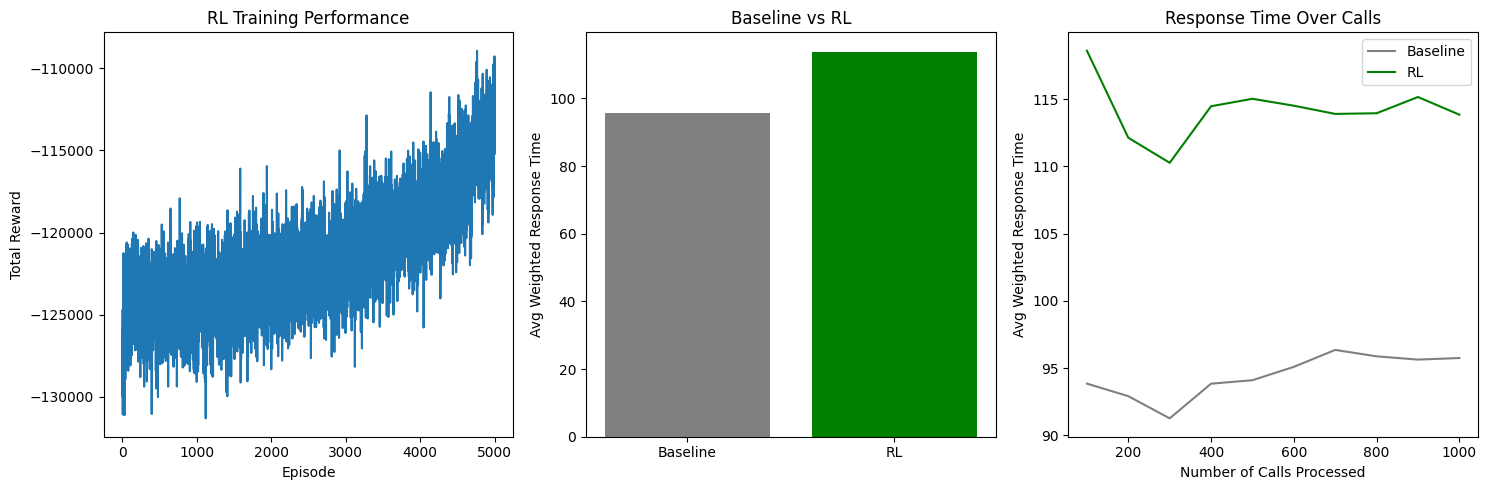

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# --- Load dataset ---
df = pd.read_csv("synthetic_calls.csv")

# Fix time column
if "timeReceived" in df.columns:
    df = df.sort_values("timeReceived").reset_index(drop=True)
elif "Timestamp" in df.columns:
    df["timeReceived"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("timeReceived").reset_index(drop=True)
else:
    df["timeReceived"] = range(len(df))

# Severity weights
severity_weights = {"Critical": 3.0, "Moderate": 2.0, "Low": 1.0}

# Extract call data
calls = df[["timeReceived", "X", "Y", "Severity"]].values

# Grid setup
GRID_SIZE = 100
AMB_SPEED = 1.0  # units per timestep

# RL parameters
Z = 5  # 5x5 zones
NUM_ZONES = Z * Z
alpha = 0.1
gamma = 0.95
epsilon = 1.0          # start fully exploring
decay = 0.995          # epsilon decay per episode
min_epsilon = 0.05
episodes = 5000        # more training

def zone_id(x, y):
    return (x // (GRID_SIZE // Z)) * Z + (y // (GRID_SIZE // Z))

# --- Environment ---
class ERSEnv:
    def __init__(self, calls):
        self.calls = calls
        self.reset()

    def reset(self):
        self.t = 0
        self.ambulance_zone = NUM_ZONES // 2
        self.done = False
        # first call
        _, x, y, sev = self.calls[self.t]
        call_zone = zone_id(x, y)
        return (self.ambulance_zone, call_zone)

    def step(self, action):
        self.ambulance_zone = action
        if self.t < len(self.calls):
            _, x, y, sev = self.calls[self.t]
            weight = severity_weights.get(sev, 1.0)
            cx, cy = divmod(self.ambulance_zone, Z)
            zx = (GRID_SIZE // Z) * cx + (GRID_SIZE // (2*Z))
            zy = (GRID_SIZE // Z) * cy + (GRID_SIZE // (2*Z))
            dist = abs(zx - x) + abs(zy - y)
            response_time = dist / AMB_SPEED
            reward = -(response_time * weight)
            call_zone = zone_id(x, y)
            state = (self.ambulance_zone, call_zone)
        else:
            reward = 0
            state = (self.ambulance_zone, 0)
        self.t += 1
        if self.t >= len(self.calls):
            self.done = True
        return state, reward, self.done

# --- Q-learning ---
Q = defaultdict(lambda: np.zeros(NUM_ZONES))
env = ERSEnv(calls)
rewards_per_episode = []

for ep in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        if random.random() < epsilon:
            action = random.randrange(NUM_ZONES)
        else:
            action = np.argmax(Q[state])
        next_state, reward, done = env.step(action)
        total_reward += reward
        best_next = np.max(Q[next_state])
        Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])
        state = next_state
    rewards_per_episode.append(total_reward)
    # decay epsilon
    epsilon = max(min_epsilon, epsilon * decay)

# --- Evaluate Baseline (central zone always) ---
def baseline_policy(calls):
    avg_times = []
    total_rt = 0
    for i, (_, x, y, sev) in enumerate(calls):
        cx, cy = divmod(NUM_ZONES // 2, Z)
        zx = (GRID_SIZE // Z) * cx + (GRID_SIZE // (2*Z))
        zy = (GRID_SIZE // Z) * cy + (GRID_SIZE // (2*Z))
        dist = abs(zx - x) + abs(zy - y)
        weight = severity_weights.get(sev, 1.0)
        total_rt += dist / AMB_SPEED * weight
        if (i+1) % 100 == 0:
            avg_times.append(total_rt / (i+1))
    return avg_times

# --- Evaluate RL policy ---
def rl_policy(calls, Q):
    env = ERSEnv(calls)
    state = env.reset()
    avg_times = []
    total_rt = 0
    count = 0
    while not env.done:
        action = np.argmax(Q[state])
        next_state, reward, done = env.step(action)
        total_rt += -reward  # negate because reward = -time
        count += 1
        if count % 100 == 0:
            avg_times.append(total_rt / count)
        state = next_state
    return avg_times

baseline_times = baseline_policy(calls)
rl_times = rl_policy(calls, Q)

print(f"Final Baseline avg weighted response time: {baseline_times[-1]:.2f}")
print(f"Final RL avg weighted response time: {rl_times[-1]:.2f}")

# --- Plots ---
plt.figure(figsize=(15,5))

# RL Training Curve
plt.subplot(1,3,1)
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("RL Training Performance")

# Comparison bar chart
plt.subplot(1,3,2)
plt.bar(["Baseline", "RL"], [baseline_times[-1], rl_times[-1]], color=["gray", "green"])
plt.ylabel("Avg Weighted Response Time")
plt.title("Baseline vs RL")

# Time-series avg response time
plt.subplot(1,3,3)
plt.plot(range(100, len(calls)+1, 100), baseline_times, label="Baseline", color="gray")
plt.plot(range(100, len(calls)+1, 100), rl_times, label="RL", color="green")
plt.xlabel("Number of Calls Processed")
plt.ylabel("Avg Weighted Response Time")
plt.title("Response Time Over Calls")
plt.legend()

plt.tight_layout()
plt.show()


Final Baseline avg weighted response time: 53.24
Final RL avg weighted response time: 127.44


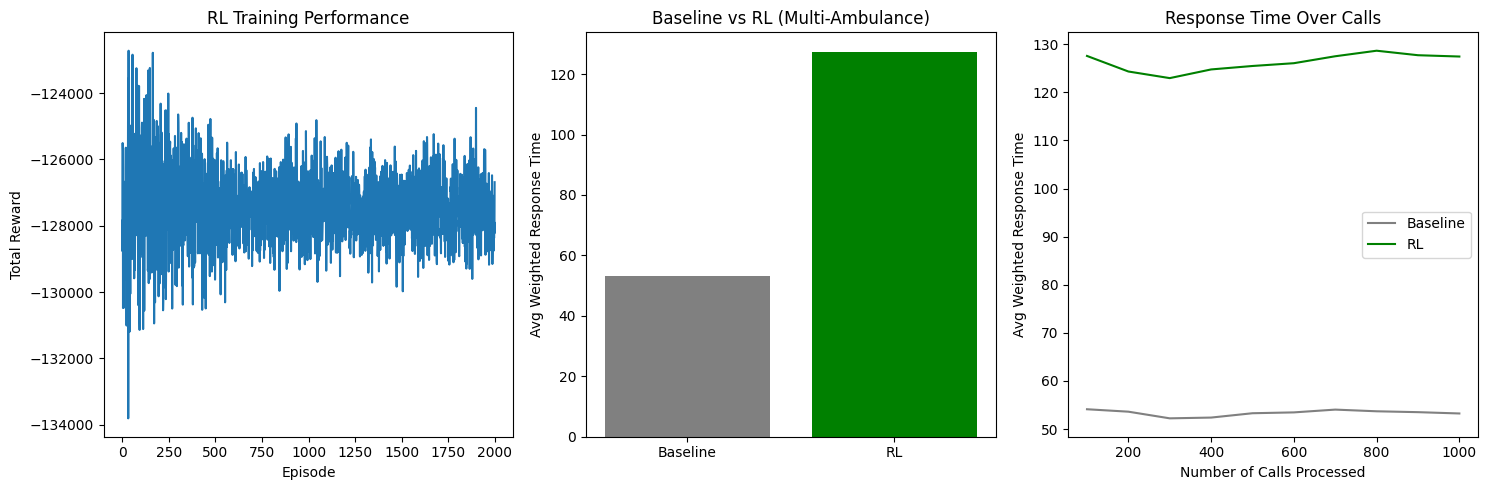

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# -------------------------
# Load dataset
# -------------------------
df = pd.read_csv("synthetic_calls.csv")

if "timeReceived" in df.columns:
    df = df.sort_values("timeReceived").reset_index(drop=True)
elif "Timestamp" in df.columns:
    df["timeReceived"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("timeReceived").reset_index(drop=True)
else:
    df["timeReceived"] = range(len(df))

# Severity weights
severity_weights = {"Critical": 3.0, "Moderate": 2.0, "Low": 1.0}

calls = df[["timeReceived", "X", "Y", "Severity"]].values

# -------------------------
# Simulation params
# -------------------------
GRID_SIZE = 100
Z = 5  # 5x5 grid zones
NUM_ZONES = Z * Z
N_AMBULANCES = 5
AMB_SPEED = 1.0

# RL params
alpha = 0.1
gamma = 0.95
epsilon = 1.0
min_epsilon = 0.05
decay = 0.995
episodes = 2000

def zone_id(x, y):
    return (x // (GRID_SIZE // Z)) * Z + (y // (GRID_SIZE // Z))

# -------------------------
# Environment
# -------------------------
class ERSMultiAmb:
    def __init__(self, calls):
        self.calls = calls
        self.reset()

    def reset(self):
        self.t = 0
        # all ambulances start in central zone
        self.ambulance_zones = [NUM_ZONES // 2 for _ in range(N_AMBULANCES)]
        self.done = False
        _, x, y, sev = self.calls[self.t]
        cz = zone_id(x, y)
        return (tuple(self.ambulance_zones), cz)

    def step(self, action):
        # action = which ambulance to dispatch (0..N_AMBULANCES-1)
        amb_id = action
        _, x, y, sev = self.calls[self.t]
        weight = severity_weights.get(sev, 1.0)

        # compute response time from ambulance to call
        ax, ay = divmod(self.ambulance_zones[amb_id], Z)
        zx = (GRID_SIZE // Z) * ax + (GRID_SIZE // (2 * Z))
        zy = (GRID_SIZE // Z) * ay + (GRID_SIZE // (2 * Z))
        dist = abs(zx - x) + abs(zy - y)
        response_time = dist / AMB_SPEED

        # move that ambulance to new call zone
        self.ambulance_zones[amb_id] = zone_id(x, y)

        reward = -(response_time * weight)

        self.t += 1
        if self.t >= len(self.calls):
            self.done = True
            next_state = None
        else:
            _, nx, ny, nsev = self.calls[self.t]
            next_state = (tuple(self.ambulance_zones), zone_id(nx, ny))
        return next_state, reward, self.done

# -------------------------
# Q-learning
# -------------------------
Q = defaultdict(lambda: np.zeros(N_AMBULANCES))
env = ERSMultiAmb(calls)
rewards_per_episode = []

for ep in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        if random.random() < epsilon:
            action = random.randrange(N_AMBULANCES)
        else:
            action = np.argmax(Q[state])
        next_state, reward, done = env.step(action)
        total_reward += reward
        if not done:
            best_next = np.max(Q[next_state])
            Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])
        state = next_state
    rewards_per_episode.append(total_reward)
    epsilon = max(min_epsilon, epsilon * decay)

# -------------------------
# Evaluation
# -------------------------
def baseline_policy(calls):
    # baseline = always dispatch nearest ambulance (all start central)
    amb_zones = [NUM_ZONES // 2 for _ in range(N_AMBULANCES)]
    total_rt = 0
    times = []
    for i, (_, x, y, sev) in enumerate(calls):
        weight = severity_weights.get(sev, 1.0)
        # choose nearest ambulance
        best_id, best_dist = None, 1e9
        for aid, zone in enumerate(amb_zones):
            ax, ay = divmod(zone, Z)
            zx = (GRID_SIZE // Z) * ax + (GRID_SIZE // (2 * Z))
            zy = (GRID_SIZE // Z) * ay + (GRID_SIZE // (2 * Z))
            dist = abs(zx - x) + abs(zy - y)
            if dist < best_dist:
                best_dist, best_id = dist, aid
        total_rt += best_dist / AMB_SPEED * weight
        amb_zones[best_id] = zone_id(x, y)
        if (i + 1) % 100 == 0:
            times.append(total_rt / (i + 1))
    return times

def rl_policy(calls, Q):
    env = ERSMultiAmb(calls)
    state = env.reset()
    total_rt = 0
    count = 0
    times = []
    while not env.done:
        action = np.argmax(Q[state])
        next_state, reward, done = env.step(action)
        total_rt += -reward
        count += 1
        if count % 100 == 0:
            times.append(total_rt / count)
        state = next_state
    return times

baseline_times = baseline_policy(calls)
rl_times = rl_policy(calls, Q)

print(f"Final Baseline avg weighted response time: {baseline_times[-1]:.2f}")
print(f"Final RL avg weighted response time: {rl_times[-1]:.2f}")

# -------------------------
# Plots
# -------------------------
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("RL Training Performance")

plt.subplot(1,3,2)
plt.bar(["Baseline", "RL"], [baseline_times[-1], rl_times[-1]], color=["gray", "green"])
plt.ylabel("Avg Weighted Response Time")
plt.title("Baseline vs RL (Multi-Ambulance)")

plt.subplot(1,3,3)
plt.plot(range(100, len(calls)+1, 100), baseline_times, label="Baseline", color="gray")
plt.plot(range(100, len(calls)+1, 100), rl_times, label="RL", color="green")
plt.xlabel("Number of Calls Processed")
plt.ylabel("Avg Weighted Response Time")
plt.title("Response Time Over Calls")
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_15520\1546590980.py:118: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  states = torch.FloatTensor(states)


Episode 0, total reward -62125.00, epsilon 0.99
Episode 20, total reward -60901.00, epsilon 0.90
Episode 40, total reward -58965.00, epsilon 0.81
Episode 60, total reward -59255.00, epsilon 0.74
Episode 80, total reward -58319.00, epsilon 0.67
Episode 100, total reward -57411.00, epsilon 0.60
Episode 120, total reward -56469.00, epsilon 0.55
Episode 140, total reward -57123.00, epsilon 0.49
Episode 160, total reward -56281.00, epsilon 0.45
Episode 180, total reward -56287.00, epsilon 0.40
Episode 200, total reward -55411.00, epsilon 0.37
Episode 220, total reward -55673.00, epsilon 0.33
Episode 240, total reward -53411.00, epsilon 0.30
Episode 260, total reward -53477.00, epsilon 0.27
Episode 280, total reward -56329.00, epsilon 0.24
Baseline avg weighted response time: 98.56
RL avg weighted response time: 109.07


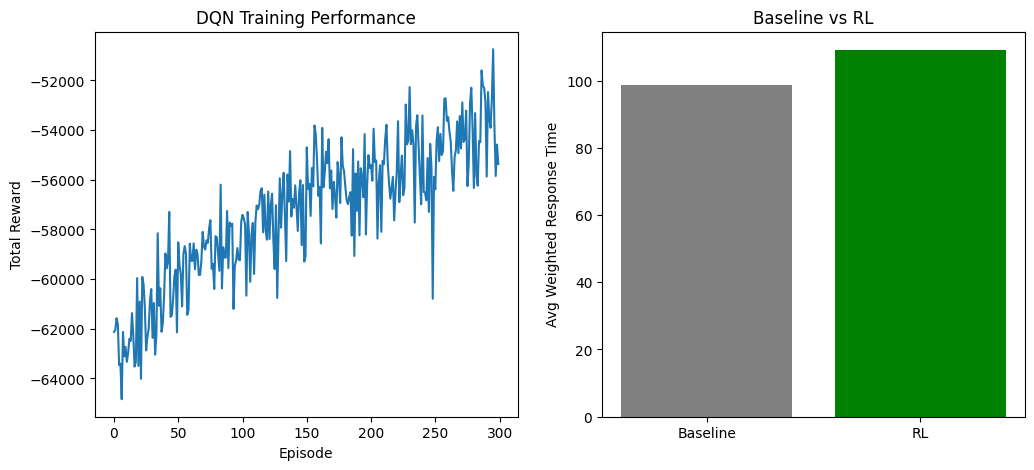

In [ ]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque, defaultdict

# -------------------------
# Load dataset
# -------------------------
df = pd.read_csv("synthetic_calls.csv")

# Make sure we have a numeric time
if "Timestamp" in df.columns:
    df["timeReceived"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("timeReceived").reset_index(drop=True)
else:
    df["timeReceived"] = range(len(df))

# Filter only ambulance-related calls
df = df[df["ResponseUnit"] == "Ambulance"].reset_index(drop=True)

# Severity weights
severity_weights = {"Critical": 3.0, "Moderate": 2.0, "Low": 1.0}

# Extract calls
calls = df[["timeReceived", "X", "Y", "Severity"]].values

# -------------------------
# Environment
# -------------------------
GRID_SIZE = 100
AMB_SPEED = 1.0
Z = 5
NUM_ZONES = Z * Z

def zone_center(zone):
    cx, cy = divmod(zone, Z)
    zx = (GRID_SIZE // Z) * cx + (GRID_SIZE // (2*Z))
    zy = (GRID_SIZE // Z) * cy + (GRID_SIZE // (2*Z))
    return zx, zy

class ERSEnv:
    def __init__(self, calls):
        self.calls = calls
        self.reset()

    def reset(self):
        self.t = 0
        self.ambulance_zone = NUM_ZONES // 2
        self.done = False
        return np.array([self.ambulance_zone], dtype=np.float32)

    def step(self, action):
        self.ambulance_zone = int(action)
        if self.t < len(self.calls):
            _, x, y, sev = self.calls[self.t]
            zx, zy = zone_center(self.ambulance_zone)
            dist = abs(zx - x) + abs(zy - y)
            response_time = dist / AMB_SPEED
            weight = severity_weights.get(sev, 1.0)
            reward = - (response_time * weight) / 100.0
        else:
            reward = 0
        self.t += 1
        if self.t >= len(self.calls):
            self.done = True
        return np.array([self.ambulance_zone], dtype=np.float32), reward, self.done

# -------------------------
# DQN setup
# -------------------------
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

def train_dqn(env, episodes=500, gamma=0.95, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, lr=0.001, batch_size=32):
    state_dim = 1
    action_dim = NUM_ZONES
    policy_net = DQN(state_dim, action_dim)
    target_net = DQN(state_dim, action_dim)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = deque(maxlen=5000)

    rewards_log = []

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            if random.random() < epsilon:
                action = random.randrange(action_dim)
            else:
                with torch.no_grad():
                    q_vals = policy_net(torch.FloatTensor(state))
                    action = torch.argmax(q_vals).item()
            next_state, reward, done = env.step(action)
            memory.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            if len(memory) >= batch_size:
                batch = random.sample(memory, batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones)

                q_vals = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    next_q = target_net(next_states).max(1)[0]
                    target = rewards + gamma * next_q * (1 - dones)
                loss = nn.MSELoss()(q_vals, target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        rewards_log.append(total_reward)

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        if ep % 20 == 0:
            target_net.load_state_dict(policy_net.state_dict())
            print(f"Episode {ep}, total reward {total_reward:.2f}, epsilon {epsilon:.2f}")

    return policy_net, rewards_log

# -------------------------
# Train RL
# -------------------------
env = ERSEnv(calls)
policy_net, rewards_log = train_dqn(env, episodes=5000)

# -------------------------
# Evaluate RL policy
# -------------------------
def evaluate_policy(env, policy_net):
    state = env.reset()
    total_rt = 0
    count = 0
    while not env.done:
        with torch.no_grad():
            q_vals = policy_net(torch.FloatTensor(state))
            action = torch.argmax(q_vals).item()
        next_state, reward, done = env.step(action)
        total_rt += -reward
        count += 1
        state = next_state
    return total_rt / count

# Baseline
def baseline_policy(calls):
    total_rt = 0
    for _, x, y, sev in calls:
        zx, zy = zone_center(NUM_ZONES // 2)
        dist = abs(zx - x) + abs(zy - y)
        weight = severity_weights.get(sev, 1.0)
        total_rt += dist * weight
    return total_rt / len(calls)

baseline_avg = baseline_policy(calls)
rl_avg = evaluate_policy(ERSEnv(calls), policy_net)

print(f"Baseline avg weighted response time: {baseline_avg:.2f}")
print(f"RL avg weighted response time: {rl_avg:.2f}")

# -------------------------
# Plots
# -------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(rewards_log)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Performance")

plt.subplot(1,2,2)
plt.bar(["Baseline", "RL"], [baseline_avg, rl_avg], color=["gray","green"])
plt.ylabel("Avg Weighted Response Time")
plt.title("Baseline vs RL")
plt.show()


Loaded 486 ambulance calls
Episode 1/1000  total_reward=-628.810  epsilon=0.995
Episode 50/1000  total_reward=-550.990  epsilon=0.778
Episode 100/1000  total_reward=-445.310  epsilon=0.606
Episode 150/1000  total_reward=-347.970  epsilon=0.471
Episode 200/1000  total_reward=-289.390  epsilon=0.367
Episode 250/1000  total_reward=-238.430  epsilon=0.286
Episode 300/1000  total_reward=-219.150  epsilon=0.222
Episode 350/1000  total_reward=-214.010  epsilon=0.173
Episode 400/1000  total_reward=-170.390  epsilon=0.135
Episode 450/1000  total_reward=-164.810  epsilon=0.105
Episode 500/1000  total_reward=-166.090  epsilon=0.082
Episode 550/1000  total_reward=-138.330  epsilon=0.063
Episode 600/1000  total_reward=-123.650  epsilon=0.050
Episode 650/1000  total_reward=-127.110  epsilon=0.050
Episode 700/1000  total_reward=-125.470  epsilon=0.050
Episode 750/1000  total_reward=-133.910  epsilon=0.050
Episode 800/1000  total_reward=-135.150  epsilon=0.050
Episode 850/1000  total_reward=-135.450  

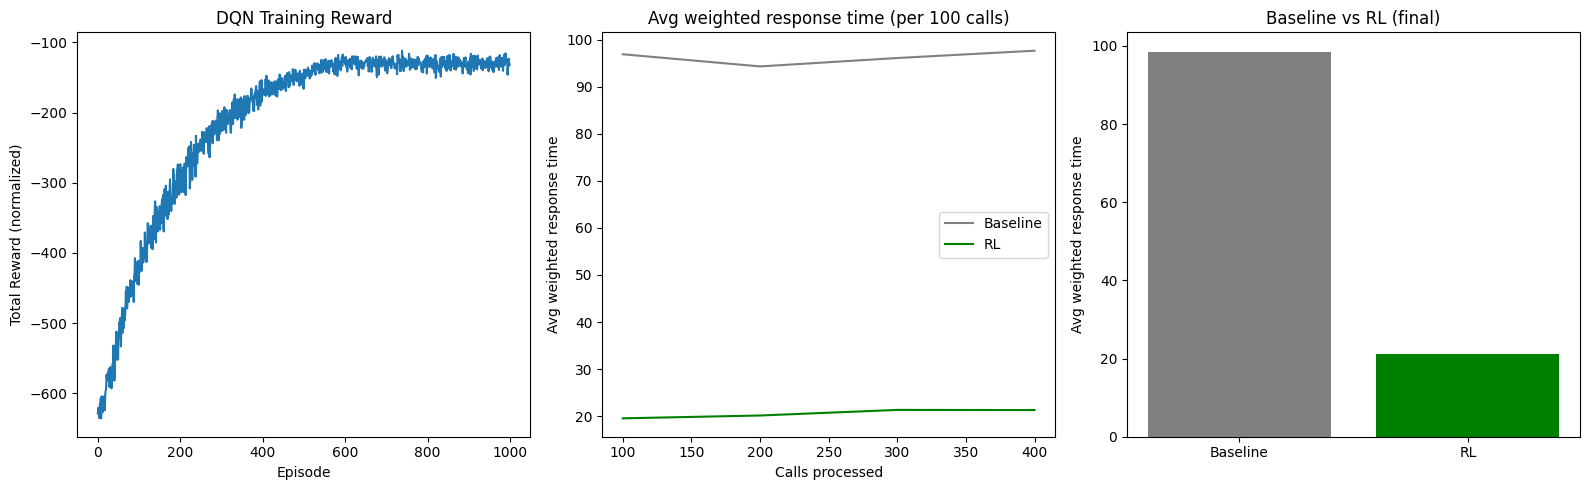

Saved policy model to dqn_ambulance_policy.pth


In [10]:
# dqn_ambulance_final.py
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import os

# -------------------------
# Config (tweakable)
# -------------------------
DATA_FILE = "synthetic_calls.csv"
GRID_SIZE = 100
Z = 5                    # grid zones per side
NUM_ZONES = Z * Z
AMB_SPEED = 1.0
SEVERITY_WEIGHTS = {"Critical": 3.0, "Moderate": 2.0, "Low": 1.0}

EPISODES = 1000          # increase for stronger training
BATCH_SIZE = 64
MEMORY_SIZE = 10000
GAMMA = 0.95
LR = 1e-3
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 0.995
TARGET_UPDATE_FREQ = 20  # update target network every N episodes
REWARD_SCALE = 100.0     # divide raw weighted response by this to keep rewards small
DEVICE = torch.device("cpu")  # change to "cuda" if you have GPU and installed torch+cuda

# -------------------------
# Load dataset + filter ambulance calls
# -------------------------
df = pd.read_csv(DATA_FILE)

# normalize / ensure timestamp exists for ordering
if "Timestamp" in df.columns:
    df["timeReceived"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("timeReceived").reset_index(drop=True)
elif "timeReceived" in df.columns:
    df = df.sort_values("timeReceived").reset_index(drop=True)
else:
    df["timeReceived"] = range(len(df))
    df = df.reset_index(drop=True)

# Filter to Ambulance calls only (important)
if "ResponseUnit" in df.columns:
    df = df[df["ResponseUnit"].str.lower().str.contains("ambul", na=False)].reset_index(drop=True)

# If severity capitalization varies, normalize
if "Severity" in df.columns:
    df["Severity"] = df["Severity"].astype(str).str.title()
else:
    df["Severity"] = "Low"

calls = df[["timeReceived", "X", "Y", "Severity"]].values
N_CALLS = len(calls)
print(f"Loaded {N_CALLS} ambulance calls")

# -------------------------
# Utility functions
# -------------------------
def zone_center(zone):
    cx, cy = divmod(int(zone), Z)
    zx = (GRID_SIZE // Z) * cx + (GRID_SIZE // (2 * Z))
    zy = (GRID_SIZE // Z) * cy + (GRID_SIZE // (2 * Z))
    return float(zx), float(zy)

def zone_of_xy(x, y):
    # x,y in [0, GRID_SIZE], map to zone index 0..NUM_ZONES-1
    zx = int(min(max(x, 0), GRID_SIZE - 1))
    zy = int(min(max(y, 0), GRID_SIZE - 1))
    zone_x = zx // (GRID_SIZE // Z)
    zone_y = zy // (GRID_SIZE // Z)
    return int(zone_x * Z + zone_y)

def weighted_response_time(ambulance_zone, call_x, call_y, severity):
    zx, zy = zone_center(ambulance_zone)
    dist = abs(zx - float(call_x)) + abs(zy - float(call_y))
    rt = dist / AMB_SPEED
    weight = SEVERITY_WEIGHTS.get(str(severity).title(), 1.0)
    return rt * weight

# -------------------------
# Environment (single ambulance, richer state)
# State: [ambulance_zone_norm, call_zone_norm, severity_weight_norm]
# -------------------------
class ERSEnv:
    def __init__(self, calls):
        self.calls = calls
        self.reset()

    def reset(self):
        self.t = 0
        self.ambulance_zone = NUM_ZONES // 2  # start center
        self.done = False
        # initial call info
        _, x, y, sev = self.calls[self.t]
        call_zone = zone_of_xy(x, y)
        state = self.make_state(self.ambulance_zone, call_zone, sev)
        return state

    def make_state(self, amb_zone, call_zone, sev):
        # normalize to [0,1]
        return np.array([
            amb_zone / (NUM_ZONES - 1),
            call_zone / (NUM_ZONES - 1),
            SEVERITY_WEIGHTS.get(str(sev).title(), 1.0) / max(SEVERITY_WEIGHTS.values())
        ], dtype=np.float32)

    def step(self, action_zone):
        # action is zone index to position ambulance BEFORE serving current call
        self.ambulance_zone = int(action_zone)
        if self.t < len(self.calls):
            _, x, y, sev = self.calls[self.t]
            rt = weighted_response_time(self.ambulance_zone, x, y, sev)
            reward = - (rt / REWARD_SCALE)   # normalized negative weighted RT
            # prepare next state
            self.t += 1
            done = (self.t >= len(self.calls))
            if not done:
                _, nx, ny, nsev = self.calls[self.t]
                next_call_zone = zone_of_xy(nx, ny)
                next_state = self.make_state(self.ambulance_zone, next_call_zone, nsev)
            else:
                next_state = np.zeros(3, dtype=np.float32)
            return next_state, reward, done
        else:
            self.t += 1
            return np.zeros(3, dtype=np.float32), 0.0, True

# -------------------------
# DQN model
# -------------------------
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)

# -------------------------
# Replay memory helper
# -------------------------
class ReplayBuffer:
    def __init__(self, maxlen=MEMORY_SIZE):
        self.buffer = deque(maxlen=maxlen)

    def push(self, s, a, r, s2, done):
        self.buffer.append((s, a, r, s2, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, d = map(np.array, zip(*batch))
        return s, a, r, s2, d

    def __len__(self):
        return len(self.buffer)

# -------------------------
# Train function
# -------------------------
def train_dqn(env, episodes=EPISODES):
    state_dim = 3
    action_dim = NUM_ZONES
    policy = DQN(state_dim, action_dim).to(DEVICE)
    target = DQN(state_dim, action_dim).to(DEVICE)
    target.load_state_dict(policy.state_dict())
    optimizer = optim.Adam(policy.parameters(), lr=LR)
    memory = ReplayBuffer(MEMORY_SIZE)

    epsilon = EPS_START
    rewards_log = []

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0.0
        done = False

        while not done:
            if random.random() < epsilon:
                action = random.randrange(action_dim)
            else:
                with torch.no_grad():
                    st = torch.from_numpy(state).unsqueeze(0).to(DEVICE)
                    qv = policy(st)
                    action = int(torch.argmax(qv).item())

            next_state, reward, done = env.step(action)
            memory.push(state, action, reward, next_state, float(done))
            state = next_state
            total_reward += reward

            if len(memory) >= BATCH_SIZE:
                s_batch, a_batch, r_batch, s2_batch, d_batch = memory.sample(BATCH_SIZE)
                # convert to tensors (use numpy -> tensor to avoid warning)
                s_batch = torch.from_numpy(s_batch).float().to(DEVICE)
                a_batch = torch.from_numpy(a_batch).long().to(DEVICE)
                r_batch = torch.from_numpy(r_batch).float().to(DEVICE)
                s2_batch = torch.from_numpy(s2_batch).float().to(DEVICE)
                d_batch = torch.from_numpy(d_batch).float().to(DEVICE)

                q_vals = policy(s_batch).gather(1, a_batch.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    next_q = target(s2_batch).max(1)[0]
                    target_q = r_batch + (1.0 - d_batch) * GAMMA * next_q
                loss = nn.MSELoss()(q_vals, target_q)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        rewards_log.append(total_reward)

        # epsilon decay
        epsilon = max(EPS_END, epsilon * EPS_DECAY)

        if (ep + 1) % TARGET_UPDATE_FREQ == 0:
            target.load_state_dict(policy.state_dict())

        if (ep + 1) % 50 == 0 or ep == 0:
            print(f"Episode {ep+1}/{episodes}  total_reward={total_reward:.3f}  epsilon={epsilon:.3f}")

    return policy, rewards_log

# -------------------------
# Evaluate functions
# -------------------------
def evaluate_policy_avg_response(policy_net, calls):
    env = ERSEnv(calls)
    state = env.reset()
    total_weighted_rt = 0.0
    count = 0
    # store per-100-call averages
    per100 = []
    while True:
        with torch.no_grad():
            st = torch.from_numpy(state).unsqueeze(0).to(DEVICE)
            qv = policy_net(st)
            action = int(torch.argmax(qv).item())
        next_state, reward, done = env.step(action)
        # reward = - (weighted_rt / REWARD_SCALE)
        total_weighted_rt += -reward * REWARD_SCALE
        count += 1
        if count % 100 == 0:
            per100.append(total_weighted_rt / count)
        state = next_state
        if done:
            break
    avg = total_weighted_rt / count if count > 0 else 0
    return avg, per100

def baseline_policy_avg_response(calls):
    # baseline: place in center zone always (static)
    total_weighted_rt = 0.0
    count = 0
    per100 = []
    center_zone = NUM_ZONES // 2
    for i, (_, x, y, sev) in enumerate(calls, start=1):
        wrt = weighted_response_time(center_zone, x, y, sev)
        total_weighted_rt += wrt
        if i % 100 == 0:
            per100.append(total_weighted_rt / i)
    avg = total_weighted_rt / len(calls) if len(calls) > 0 else 0
    return avg, per100

# -------------------------
# Run training + evaluation
# -------------------------
env = ERSEnv(calls)
policy_net, rewards_log = train_dqn(env, episodes=EPISODES)

# Evaluate
baseline_avg, baseline_ts = baseline_policy_avg_response(calls)
rl_avg, rl_ts = evaluate_policy_avg_response(policy_net, calls)

print("\n=== Results ===")
print(f"Baseline avg weighted response time: {baseline_avg:.2f}")
print(f"RL avg weighted response time: {rl_avg:.2f}")

# -------------------------
# Plots: training curve, time series per 100 calls, comparison bar
# -------------------------
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(rewards_log)
plt.xlabel("Episode")
plt.ylabel("Total Reward (normalized)")
plt.title("DQN Training Reward")

plt.subplot(1,3,2)
# x axis for time series
xs = list(range(100, N_CALLS + 1, 100))[:len(baseline_ts)]
plt.plot(xs, baseline_ts, label="Baseline", color="gray")
plt.plot(xs, rl_ts, label="RL", color="green")
plt.xlabel("Calls processed")
plt.ylabel("Avg weighted response time")
plt.title("Avg weighted response time (per 100 calls)")
plt.legend()

plt.subplot(1,3,3)
plt.bar(["Baseline", "RL"], [baseline_avg, rl_avg], color=["gray", "green"])
plt.ylabel("Avg weighted response time")
plt.title("Baseline vs RL (final)")

plt.tight_layout()
plt.show()

# Save model checkpoint
MODEL_PATH = "dqn_ambulance_policy.pth"
torch.save(policy_net.state_dict(), MODEL_PATH)
print(f"Saved policy model to {MODEL_PATH}")


In [11]:
# multi_unit_dqn.py
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from collections import deque, defaultdict

# -------------------------
# Config
# -------------------------
DATA_FILE = "synthetic_calls.csv"
GRID_SIZE = 100
Z = 5
NUM_ZONES = Z * Z
SEVERITY_WEIGHTS = {"Critical": 3.0, "Moderate": 2.0, "Low": 1.0}
UNIT_SPEEDS = {"Ambulance": 1.0, "Fire Truck": 0.8, "Police": 1.2}  # tweakable

EPISODES = 1000
BATCH_SIZE = 64
MEMORY_SIZE = 10000
GAMMA = 0.95
LR = 1e-3
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 0.995
TARGET_UPDATE_FREQ = 20
REWARD_SCALE = 100.0
DEVICE = torch.device("cpu")

# -------------------------
# Data load
# -------------------------
df = pd.read_csv(DATA_FILE)

if "Timestamp" in df.columns:
    df["timeReceived"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("timeReceived").reset_index(drop=True)
else:
    df["timeReceived"] = range(len(df))

df["Severity"] = df["Severity"].astype(str).str.title()
df["ResponseUnit"] = df["ResponseUnit"].astype(str).str.title()

def zone_center(zone):
    cx, cy = divmod(int(zone), Z)
    zx = (GRID_SIZE // Z) * cx + (GRID_SIZE // (2 * Z))
    zy = (GRID_SIZE // Z) * cy + (GRID_SIZE // (2 * Z))
    return float(zx), float(zy)

def zone_of_xy(x, y):
    zx = int(min(max(x, 0), GRID_SIZE - 1))
    zy = int(min(max(y, 0), GRID_SIZE - 1))
    zone_x = zx // (GRID_SIZE // Z)
    zone_y = zy // (GRID_SIZE // Z)
    return int(zone_x * Z + zone_y)

def weighted_response_time(zone, x, y, sev, unit_type):
    zx, zy = zone_center(zone)
    dist = abs(zx - float(x)) + abs(zy - float(y))
    rt = dist / UNIT_SPEEDS[unit_type]
    return rt * SEVERITY_WEIGHTS.get(sev, 1.0)

# -------------------------
# Environment (per unit)
# -------------------------
class ERSEnv:
    def __init__(self, calls, unit_type):
        self.calls = calls
        self.unit_type = unit_type
        self.reset()

    def reset(self):
        self.t = 0
        self.unit_zone = NUM_ZONES // 2
        self.done = False
        _, x, y, sev = self.calls[self.t]
        call_zone = zone_of_xy(x, y)
        return self.make_state(self.unit_zone, call_zone, sev)

    def make_state(self, unit_zone, call_zone, sev):
        return np.array([
            unit_zone / (NUM_ZONES - 1),
            call_zone / (NUM_ZONES - 1),
            SEVERITY_WEIGHTS.get(sev, 1.0) / max(SEVERITY_WEIGHTS.values())
        ], dtype=np.float32)

    def step(self, action_zone):
        self.unit_zone = int(action_zone)
        if self.t < len(self.calls):
            _, x, y, sev = self.calls[self.t]
            rt = weighted_response_time(self.unit_zone, x, y, sev, self.unit_type)
            reward = - (rt / REWARD_SCALE)
            self.t += 1
            done = (self.t >= len(self.calls))
            if not done:
                _, nx, ny, nsev = self.calls[self.t]
                next_call_zone = zone_of_xy(nx, ny)
                next_state = self.make_state(self.unit_zone, next_call_zone, nsev)
            else:
                next_state = np.zeros(3, dtype=np.float32)
            return next_state, reward, done
        else:
            return np.zeros(3, dtype=np.float32), 0.0, True

# -------------------------
# DQN + Replay buffer
# -------------------------
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
    def forward(self, x): return self.net(x)

class ReplayBuffer:
    def __init__(self, maxlen=MEMORY_SIZE):
        self.buffer = deque(maxlen=maxlen)
    def push(self, s, a, r, s2, d): self.buffer.append((s,a,r,s2,d))
    def sample(self, bs): return map(np.array, zip(*random.sample(self.buffer, bs)))
    def __len__(self): return len(self.buffer)

def train_dqn(env, episodes=EPISODES):
    state_dim, action_dim = 3, NUM_ZONES
    policy, target = DQN(state_dim, action_dim).to(DEVICE), DQN(state_dim, action_dim).to(DEVICE)
    target.load_state_dict(policy.state_dict())
    opt = optim.Adam(policy.parameters(), lr=LR)
    memory, rewards_log = ReplayBuffer(), []
    epsilon = EPS_START

    for ep in range(episodes):
        state, done, total_reward = env.reset(), False, 0
        while not done:
            if random.random() < epsilon:
                action = random.randrange(action_dim)
            else:
                with torch.no_grad():
                    action = int(torch.argmax(policy(torch.from_numpy(state).unsqueeze(0))).item())
            next_state, reward, done = env.step(action)
            memory.push(state, action, reward, next_state, float(done))
            state, total_reward = next_state, total_reward + reward

            if len(memory) >= BATCH_SIZE:
                s, a, r, s2, d = memory.sample(BATCH_SIZE)
                s, a, r, s2, d = map(lambda x: torch.tensor(x, dtype=torch.float32), (s, a, r, s2, d))
                a = a.long()
                q_vals = policy(s).gather(1, a.unsqueeze(1)).squeeze(1)
                with torch.no_grad(): next_q = target(s2).max(1)[0]
                loss = nn.MSELoss()(q_vals, r + (1-d)*GAMMA*next_q)
                opt.zero_grad(); loss.backward(); opt.step()

        rewards_log.append(total_reward)
        epsilon = max(EPS_END, epsilon * EPS_DECAY)
        if (ep+1) % TARGET_UPDATE_FREQ == 0: target.load_state_dict(policy.state_dict())
    return policy, rewards_log

# -------------------------
# Evaluation
# -------------------------
def evaluate_policy(policy, calls, unit_type):
    env, state = ERSEnv(calls, unit_type), None
    state, total, count = env.reset(), 0, 0
    while True:
        with torch.no_grad():
            action = int(torch.argmax(policy(torch.from_numpy(state).unsqueeze(0))).item())
        next_state, reward, done = env.step(action)
        total += -reward * REWARD_SCALE
        count += 1
        state = next_state
        if done: break
    return total / count

def baseline_policy(calls, unit_type):
    total, count = 0, 0
    center_zone = NUM_ZONES // 2
    for _, x, y, sev in calls:
        total += weighted_response_time(center_zone, x, y, sev, unit_type)
        count += 1
    return total / count

# -------------------------
# Run for each ResponseUnit
# -------------------------
results = {}
for unit in ["Ambulance", "Fire Truck", "Police"]:
    calls_unit = df[df["ResponseUnit"] == unit][["timeReceived","X","Y","Severity"]].values
    if len(calls_unit) == 0: continue
    env = ERSEnv(calls_unit, unit)
    policy, rewards = train_dqn(env)
    rl_avg = evaluate_policy(policy, calls_unit, unit)
    base_avg = baseline_policy(calls_unit, unit)
    results[unit] = {"Baseline": base_avg, "RL": rl_avg}

print("\n=== Results by Response Unit ===")
for k,v in results.items(): print(k, v)

# Breakdown by severity + incident type
print("\n=== Severity Breakdown ===")
print(df.groupby(["ResponseUnit","Severity"]).size())
print("\n=== Incident Breakdown ===")
print(df.groupby(["ResponseUnit","IncidentType"]).size())

# Plot results
plt.bar([f"{u}-Baseline" for u in results] + [f"{u}-RL" for u in results],
        [results[u]["Baseline"] for u in results] + [results[u]["RL"] for u in results],
        color=["gray"]*len(results) + ["green"]*len(results))
plt.ylabel("Avg Weighted Response Time")
plt.title("Baseline vs RL (per Response Unit)")
plt.xticks(rotation=45)
plt.show()


KeyboardInterrupt: 

In [ ]:
# multi_unit_full.py
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from collections import deque
import os

# -------------------------
# Config
# -------------------------
DATA_FILE = "synthetic_calls.csv"
GRID_SIZE = 100
Z = 5
NUM_ZONES = Z * Z
SEVERITY_WEIGHTS = {"Critical": 3.0, "Moderate": 2.0, "Low": 1.0}
UNIT_SPEEDS = {"Ambulance": 1.0, "Fire Truck": 0.8, "Police": 1.2}  # adjust if needed

EPISODES = 1000
BATCH_SIZE = 64
MEMORY_SIZE = 10000
GAMMA = 0.95
LR = 1e-3
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 0.995
TARGET_UPDATE_FREQ = 20
REWARD_SCALE = 100.0
DEVICE = torch.device("cpu")  # or "cuda" if you have GPU and torch+cuda installed

# -------------------------
# Load and prepare data
# -------------------------
df = pd.read_csv(DATA_FILE)

# Ensure a time column for ordering
if "Timestamp" in df.columns:
    df["timeReceived"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("timeReceived").reset_index(drop=True)
elif "timeReceived" in df.columns:
    df = df.sort_values("timeReceived").reset_index(drop=True)
else:
    df["timeReceived"] = range(len(df))

# Normalize text columns
if "Severity" in df.columns:
    df["Severity"] = df["Severity"].astype(str).str.title()
else:
    df["Severity"] = "Low"

if "ResponseUnit" in df.columns:
    df["ResponseUnit"] = df["ResponseUnit"].astype(str).str.title()
else:
    df["ResponseUnit"] = "Ambulance"

if "IncidentType" not in df.columns:
    df["IncidentType"] = "Unknown"

# Helper: map (x,y) to zone index
def zone_of_xy(x, y):
    zx = int(min(max(float(x), 0), GRID_SIZE - 1))
    zy = int(min(max(float(y), 0), GRID_SIZE - 1))
    zone_x = zx // (GRID_SIZE // Z)
    zone_y = zy // (GRID_SIZE // Z)
    return int(zone_x * Z + zone_y)

def zone_center(zone):
    cx, cy = divmod(int(zone), Z)
    zx = (GRID_SIZE // Z) * cx + (GRID_SIZE // (2 * Z))
    zy = (GRID_SIZE // Z) * cy + (GRID_SIZE // (2 * Z))
    return float(zx), float(zy)

def weighted_response_time(zone, x, y, sev, unit_type):
    zx, zy = zone_center(zone)
    dist = abs(zx - float(x)) + abs(zy - float(y))
    rt = dist / UNIT_SPEEDS.get(unit_type, 1.0)
    return rt * SEVERITY_WEIGHTS.get(str(sev).title(), 1.0)

# -------------------------
# DQN components (same pattern as your working ambulance code)
# -------------------------
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, maxlen=MEMORY_SIZE):
        self.buffer = deque(maxlen=maxlen)
    def push(self, s, a, r, s2, d):
        self.buffer.append((s, a, r, s2, d))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, d = map(np.array, zip(*batch))
        return s, a, r, s2, d
    def __len__(self):
        return len(self.buffer)

# -------------------------
# Environment (single-unit DQN)
# State: [unit_zone_norm, call_zone_norm, severity_norm]
# -------------------------
class ERSEnv:
    def __init__(self, calls_array, unit_type):
        # calls_array: numpy array rows [timeReceived, X, Y, Severity, IncidentType(optional)]
        self.calls = calls_array
        self.unit_type = unit_type
        self.reset()

    def reset(self):
        self.t = 0
        self.unit_zone = NUM_ZONES // 2
        self.done = False
        # initial call
        _, x, y, sev = self.calls[self.t][:4]
        call_zone = zone_of_xy(x, y)
        return self.make_state(self.unit_zone, call_zone, sev)

    def make_state(self, unit_zone, call_zone, sev):
        return np.array([
            unit_zone / (NUM_ZONES - 1),
            call_zone / (NUM_ZONES - 1),
            SEVERITY_WEIGHTS.get(str(sev).title(), 1.0) / max(SEVERITY_WEIGHTS.values())
        ], dtype=np.float32)

    def step(self, action_zone):
        self.unit_zone = int(action_zone)
        if self.t < len(self.calls):
            _, x, y, sev = self.calls[self.t][:4]
            rt = weighted_response_time(self.unit_zone, x, y, sev, self.unit_type)
            reward = - (rt / REWARD_SCALE)
            self.t += 1
            done = (self.t >= len(self.calls))
            if not done:
                _, nx, ny, nsev = self.calls[self.t][:4]
                next_call_zone = zone_of_xy(nx, ny)
                next_state = self.make_state(self.unit_zone, next_call_zone, nsev)
            else:
                next_state = np.zeros(3, dtype=np.float32)
            return next_state, reward, done
        else:
            return np.zeros(3, dtype=np.float32), 0.0, True

# -------------------------
# Train DQN for one unit
# -------------------------
def train_dqn_for_unit(calls_array, unit_type, episodes=EPISODES):
    state_dim = 3
    action_dim = NUM_ZONES
    policy = DQN(state_dim, action_dim).to(DEVICE)
    target = DQN(state_dim, action_dim).to(DEVICE)
    target.load_state_dict(policy.state_dict())
    optimizer = optim.Adam(policy.parameters(), lr=LR)
    memory = ReplayBuffer(MEMORY_SIZE)

    env = ERSEnv(calls_array, unit_type)
    epsilon = EPS_START
    rewards_log = []

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0.0
        done = False
        while not done:
            if random.random() < epsilon:
                action = random.randrange(action_dim)
            else:
                with torch.no_grad():
                    st = torch.from_numpy(state).unsqueeze(0).to(DEVICE)
                    qv = policy(st)
                    action = int(torch.argmax(qv).item())

            next_state, reward, done = env.step(action)
            memory.push(state, action, reward, next_state, float(done))
            state = next_state
            total_reward += reward

            if len(memory) >= BATCH_SIZE:
                s_batch, a_batch, r_batch, s2_batch, d_batch = memory.sample(BATCH_SIZE)
                s_batch = torch.from_numpy(s_batch).float().to(DEVICE)
                a_batch = torch.from_numpy(a_batch).long().to(DEVICE)
                r_batch = torch.from_numpy(r_batch).float().to(DEVICE)
                s2_batch = torch.from_numpy(s2_batch).float().to(DEVICE)
                d_batch = torch.from_numpy(d_batch).float().to(DEVICE)

                q_vals = policy(s_batch).gather(1, a_batch.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    next_q = target(s2_batch).max(1)[0]
                    target_q = r_batch + (1.0 - d_batch) * GAMMA * next_q
                loss = nn.MSELoss()(q_vals, target_q)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        rewards_log.append(total_reward)
        epsilon = max(EPS_END, epsilon * EPS_DECAY)
        if (ep + 1) % TARGET_UPDATE_FREQ == 0:
            target.load_state_dict(policy.state_dict())
        if (ep + 1) % 50 == 0 or ep == 0:
            print(f"[{unit_type}] Episode {ep+1}/{episodes}  total_reward={total_reward:.3f}  epsilon={epsilon:.3f}")

    return policy, rewards_log

# -------------------------
# Evaluate helpers
# -------------------------
def evaluate_policy_avg_response(policy_net, calls_array, unit_type):
    env = ERSEnv(calls_array, unit_type)
    state = env.reset()
    total_weighted_rt = 0.0
    count = 0
    per100 = []
    while True:
        with torch.no_grad():
            st = torch.from_numpy(state).unsqueeze(0).to(DEVICE)
            qv = policy_net(st)
            action = int(torch.argmax(qv).item())
        next_state, reward, done = env.step(action)
        total_weighted_rt += -reward * REWARD_SCALE
        count += 1
        if count % 100 == 0:
            per100.append(total_weighted_rt / count)
        state = next_state
        if done:
            break
    avg = total_weighted_rt / count if count > 0 else 0
    return avg, per100

def baseline_policy_avg_response(calls_array, unit_type):
    total_weighted_rt = 0.0
    count = 0
    per100 = []
    center_zone = NUM_ZONES // 2
    for i, (_, x, y, sev, *rest) in enumerate(calls_array, start=1):
        wrt = weighted_response_time(center_zone, x, y, sev, unit_type)
        total_weighted_rt += wrt
        if i % 100 == 0:
            per100.append(total_weighted_rt / i)
        count += 1
    avg = total_weighted_rt / count if count > 0 else 0
    return avg, per100

# -------------------------
# Run training and evaluation for each ResponseUnit
# -------------------------
units = df["ResponseUnit"].unique().tolist()
results = {}
severity_results = {}
incident_results = {}

for unit in units:
    calls_unit_df = df[df["ResponseUnit"] == unit].copy()
    if len(calls_unit_df) == 0:
        continue
    # prepare numpy array rows: [timeReceived, X, Y, Severity, IncidentType]
    calls_array = calls_unit_df[["timeReceived", "X", "Y", "Severity", "IncidentType"]].values

    print(f"\nTraining DQN for {unit} on {len(calls_array)} calls...")
    policy_net, rewards_log = train_dqn_for_unit(calls_array, unit, episodes=EPISODES)

    # overall evaluation
    base_avg, base_ts = baseline_policy_avg_response(calls_array, unit)
    rl_avg, rl_ts = evaluate_policy_avg_response(policy_net, calls_array, unit)
    results[unit] = {"Baseline": base_avg, "RL": rl_avg, "baseline_ts": base_ts, "rl_ts": rl_ts, "rewards_log": rewards_log}

    # severity breakdown
    severity_results[unit] = {}
    for sev in sorted(SEVERITY_WEIGHTS.keys(), key=lambda s: SEVERITY_WEIGHTS[s], reverse=True):
        calls_sev_df = calls_unit_df[calls_unit_df["Severity"] == sev]
        if len(calls_sev_df) == 0:
            continue
        calls_sev_array = calls_sev_df[["timeReceived", "X", "Y", "Severity", "IncidentType"]].values
        bavg, _ = baseline_policy_avg_response(calls_sev_array, unit)
        ravg, _ = evaluate_policy_avg_response(policy_net, calls_sev_array, unit)
        severity_results[unit][sev] = {"Baseline": bavg, "RL": ravg}

    # incident type breakdown (top N incident types for that unit)
    incident_results[unit] = {}
    top_incidents = calls_unit_df["IncidentType"].value_counts().index.tolist()[:12]  # limit to top 12 for plotting clarity
    for incident in top_incidents:
        calls_inc_df = calls_unit_df[calls_unit_df["IncidentType"] == incident]
        calls_inc_array = calls_inc_df[["timeReceived", "X", "Y", "Severity", "IncidentType"]].values
        bavg, _ = baseline_policy_avg_response(calls_inc_array, unit)
        ravg, _ = evaluate_policy_avg_response(policy_net, calls_inc_array, unit)
        incident_results[unit][incident] = {"Baseline": bavg, "RL": ravg, "count": len(calls_inc_array)}

# -------------------------
# Print summary tables
# -------------------------
print("\n=== Overall Results by Unit ===")
for u, v in results.items():
    print(f"{u}: Baseline={v['Baseline']:.2f}  RL={v['RL']:.2f}")

print("\n=== Severity Results ===")
for u, sevdict in severity_results.items():
    print(f"\n{u}:")
    for sev, vals in sevdict.items():
        print(f"  {sev}: Baseline={vals['Baseline']:.2f}, RL={vals['RL']:.2f}")

print("\n=== Incident-type Results (top incidents per unit) ===")
for u, incdict in incident_results.items():
    print(f"\n{u}:")
    for inc, vals in incdict.items():
        print(f"  {inc} (n={vals['count']}): Baseline={vals['Baseline']:.2f}, RL={vals['RL']:.2f}")

# -------------------------
# Plotting
# -------------------------
# Overall units bar chart
plt.figure(figsize=(10,5))
x = np.arange(len(results))
base_vals = [results[u]["Baseline"] for u in results]
rl_vals = [results[u]["RL"] for u in results]
width = 0.35
plt.bar(x - width/2, base_vals, width, label="Baseline", color="gray")
plt.bar(x + width/2, rl_vals, width, label="RL", color="green")
plt.xticks(x, list(results.keys()))
plt.ylabel("Avg Weighted Response Time")
plt.title("Baseline vs RL (per Response Unit)")
plt.legend()
plt.tight_layout()
plt.show()

# Severity plots per unit
for unit, sevdict in severity_results.items():
    plt.figure(figsize=(7,4))
    sev_labels = list(sevdict.keys())
    base_vals = [sevdict[s]["Baseline"] for s in sev_labels]
    rl_vals = [sevdict[s]["RL"] for s in sev_labels]
    x = np.arange(len(sev_labels))
    width = 0.35
    plt.bar(x - width/2, base_vals, width, label="Baseline", color="gray")
    plt.bar(x + width/2, rl_vals, width, label="RL", color="green")
    plt.xticks(x, sev_labels)
    plt.ylabel("Avg Weighted Response Time")
    plt.title(f"{unit} - Severity Breakdown")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Incident-type plots per unit (only if there are incidents)
for unit, incdict in incident_results.items():
    if len(incdict) == 0:
        continue
    plt.figure(figsize=(10,5))
    inc_labels = list(incdict.keys())
    base_vals = [incdict[i]["Baseline"] for i in inc_labels]
    rl_vals = [incdict[i]["RL"] for i in inc_labels]
    x = np.arange(len(inc_labels))
    width = 0.35
    plt.bar(x - width/2, base_vals, width, label="Baseline", color="gray")
    plt.bar(x + width/2, rl_vals, width, label="RL", color="green")
    plt.xticks(x, inc_labels, rotation=45, ha="right")
    plt.ylabel("Avg Weighted Response Time")
    plt.title(f"{unit} - Incident Type Breakdown (top incidents)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Save summary CSVs (optional)
summary_dir = "dqn_unit_results"
os.makedirs(summary_dir, exist_ok=True)
pd.DataFrame([{ "Unit": u, "Baseline": results[u]["Baseline"], "RL": results[u]["RL"] } for u in results]).to_csv(os.path.join(summary_dir, "unit_overall.csv"), index=False)

# severity CSV
sev_rows = []
for u, sevdict in severity_results.items():
    for sev, v in sevdict.items():
        sev_rows.append({"Unit": u, "Severity": sev, "Baseline": v["Baseline"], "RL": v["RL"]})
pd.DataFrame(sev_rows).to_csv(os.path.join(summary_dir, "unit_severity.csv"), index=False)

# incident CSV
inc_rows = []
for u, incdict in incident_results.items():
    for inc, v in incdict.items():
        inc_rows.append({"Unit": u, "IncidentType": inc, "Count": v["count"], "Baseline": v["Baseline"], "RL": v["RL"]})
pd.DataFrame(inc_rows).to_csv(os.path.join(summary_dir, "unit_incident.csv"), index=False)

print(f"\nSaved CSV summaries to folder: {summary_dir}")


# -------------------------
# Erlang-C M/M/c Validation
# -------------------------
def erlang_c(arrival_rate, service_rate, servers):
    rho = arrival_rate / (servers * service_rate)
    if rho >= 1:
        return None  # unstable
    # compute Erlang C probability of wait
    sum_terms = sum((arrival_rate/service_rate)**n / np.math.factorial(n) for n in range(servers))
    last_term = ((arrival_rate/service_rate)**servers) / (np.math.factorial(servers) * (1 - rho))
    p0 = 1 / (sum_terms + last_term)
    pw = last_term * p0
    lq = pw * (rho / (1 - rho))
    wq = lq / arrival_rate
    ws = wq + 1/service_rate
    return {"rho": rho, "Pw": pw, "Lq": lq, "Wq": wq, "Ws": ws}

print("\n=== Erlang-C Theoretical Validation ===")
# Example: assume mean arrival λ = calls per unit time, mean service μ = 1/mean_response_time
for unit, vals in results.items():
    avg_rt = vals["Baseline"]  # use baseline avg as proxy for service time
    if avg_rt <= 0:
        continue
    service_rate = 1 / avg_rt
    arrival_rate = len(df[df["ResponseUnit"] == unit]) / len(df)  # simple λ approx
    servers = 3  # e.g., 3 vehicles per unit
    res = erlang_c(arrival_rate, service_rate, servers)
    if res:
        print(f"{unit}: ρ={res['rho']:.2f}, Pw={res['Pw']:.2f}, Wq={res['Wq']:.2f}, Ws={res['Ws']:.2f}")
    else:
        print(f"{unit}: system unstable (ρ >= 1)")



Training DQN for Ambulance on 486 calls...
[Ambulance] Episode 1/1000  total_reward=-630.590  epsilon=0.995
[Ambulance] Episode 50/1000  total_reward=-537.110  epsilon=0.778
[Ambulance] Episode 100/1000  total_reward=-421.590  epsilon=0.606
[Ambulance] Episode 150/1000  total_reward=-348.550  epsilon=0.471
[Ambulance] Episode 200/1000  total_reward=-303.650  epsilon=0.367
[Ambulance] Episode 250/1000  total_reward=-243.070  epsilon=0.286
[Ambulance] Episode 300/1000  total_reward=-229.330  epsilon=0.222
[Ambulance] Episode 350/1000  total_reward=-185.570  epsilon=0.173
[Ambulance] Episode 400/1000  total_reward=-177.210  epsilon=0.135
[Ambulance] Episode 450/1000  total_reward=-139.630  epsilon=0.105
[Ambulance] Episode 500/1000  total_reward=-147.350  epsilon=0.082
[Ambulance] Episode 550/1000  total_reward=-130.550  epsilon=0.063
[Ambulance] Episode 600/1000  total_reward=-130.610  epsilon=0.050
[Ambulance] Episode 650/1000  total_reward=-129.730  epsilon=0.050
[Ambulance] Episode 7